# Participant Catchment Map via Postcode

This notebook visualises where our study participants are coming from. We compare a few plot styles (point map, proportional circles, and postcode polygons) and show how design choices (colour scale, radius scaling, binning vs continuous colour) affect interpretability. 

We are using Australian postcodes as an example. While the plots themselves are generalisable, the input, i.e., shapefiles for postcode areas and coordinates for postcode area centre, would need to be amended when working with different countries.

## Data preparation
Import libraries first.

In [1]:
import folium #  needed for interactive leaflet maps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

For the demo, we will use a publicly available dataset with the same kind of structure as many research datasets collected via online health surveys or tasks, where **postcode is recorded as a participant response**. 

**Public example data**:

NSW Boat Registrations and Licences  by Display Name and Postcode (Jan 2026) is used here as an example of a public postcode-count dataset.
Source: NSW Government open data portal (https://data.nsw.gov.au).
Licence: Creative Commons Attribution (CC BY).

Outside of this notebook, the NSW Boat Registrations and Licences data has been prepped in a way that we have the number of licenses available per postcode.

Import the data:

In [2]:
df = pd.read_csv("example_data.csv")
df.head(5)

postcode  total_licences
0      2540           10466
1      2259           10297
2      2250            9100
3      2756            9022
4      2650            8176

In this demo, we use `total_licences` as a stand-in for “number of participants per postcode”, because it’s public data with the same shape (postcode + count). **If you’re working with your own cohort data, swap 'total_licences' with your participant-count column and everything else stays the same.**

Define the count column:

In [3]:
COUNT_COL = "total_licences"          # swap to "n_participants" for real cohort

Before we get to plotting the data, we'll need to **add some geographical info**. 

A list of postcodes and their respective geographical coordinates can be found here: https://github.com/matthewproctor/australianpostcodes

If your participants are from other countries, you’ll need an equivalent dataset with postcode area centroids for that country.

In [4]:
# Load postcode data
postcodes_df = pd.read_csv(
    "australian_postcodes.csv", # retrieved 07 Jul 2025
    usecols=["postcode", "locality", "state", "long", "lat"]
)
postcodes_df.dropna(subset=["long", "lat"], inplace=True)
postcodes_df = postcodes_df.rename(columns={"long": "postcode_long", "lat": "postcode_lat"})

In [5]:
# check for duplicate postcodes
duplicate_postcodes_count = postcodes_df['postcode'].duplicated().sum()
duplicate_postcodes_count

15352

In [6]:
# Average lat/long for duplicate postcodes in postcodes_df
postcodes_df_averaged = postcodes_df.groupby('postcode')[['postcode_long', 'postcode_lat']].mean().reset_index()

Before we merge `df` and `postcodes_df_averaged`, we need to ensure both postcode columns are in the same format.


In [7]:
def clean_postcode(s: pd.Series) -> pd.Series:
    # keep only the first 4-digit sequence; handles "2000.0", " NSW 2000", "2000-2001", etc.
    s = s.astype("string").str.strip()
    s = s.str.replace(r"\.0$", "", regex=True)               # drop trailing .0
    s = s.str.extract(r"(\d{4})", expand=False)              # take first 4 digits
    s = s.fillna(pd.NA)
    return s

# Clean BOTH sides identically
df["postcode"] = clean_postcode(df["postcode"])
postcodes_df_averaged["postcode"] = clean_postcode(postcodes_df_averaged["postcode"])

# Drop rows with missing/invalid postcodes before merge
df_clean = df.dropna(subset=["postcode"]).copy()
pc_lookup = postcodes_df_averaged.dropna(subset=["postcode"]).copy()

# Ensure lookup is unique per postcode 
dupes = pc_lookup["postcode"][pc_lookup["postcode"].duplicated()].unique()
print("Duplicate postcodes in lookup:", dupes[:10], "..." if len(dupes) > 10 else "")

pc_lookup = pc_lookup.drop_duplicates(subset=["postcode"], keep="first")

Duplicate postcodes in lookup: <StringArray>
[]
Length: 0, dtype: string 


In [8]:
# Merge with validation to catch issues early
df_merged = df_clean.merge(
    pc_lookup[["postcode", "postcode_long", "postcode_lat"]],
    on="postcode",
    how="left",
    validate="m:1"   # many df rows to one postcode row
)

# Diagnose unmatched postcodes ---
missing = df_merged[df_merged["postcode_lat"].isna() | df_merged["postcode_long"].isna()]
print("Rows with missing lat/long:", len(missing))
print("Unique unmatched postcodes:", missing["postcode"].nunique())
print("Examples of unmatched postcodes:", missing["postcode"].dropna().unique()[:20])

# Check overlap (should be high)
overlap = set(df_clean["postcode"].unique()) & set(pc_lookup["postcode"].unique())
print("Unique postcodes in df:", df_clean["postcode"].nunique())
print("Unique postcodes in lookup:", pc_lookup["postcode"].nunique())
print("Unique overlap:", len(overlap))

Rows with missing lat/long: 142
Unique unmatched postcodes: 142
Examples of unmatched postcodes: <StringArray>
['2755', '1496', '2740', '2394', '2301', '2385', '2407', '1701', '1986',
 '1985', '1984', '1898', '1050', '3613', '2695', '2547', '1071', '5750',
 '1983', '1739']
Length: 20, dtype: string
Unique postcodes in df: 2499
Unique postcodes in lookup: 3124
Unique overlap: 2357


The unmatched postcodes, e.g., 2755, exist in `df_clean` but don’t have a match in `pc_lookup`.
    
If you want to sanity-check any of the postcodes that didn’t match (e.g., because they might be special-purpose or outdated codes), you can look them up using [Australia Post’s official postcode finder](https://auspost.com.au/postcode/2755). 

We'll skip this and work with the merged data:

In [9]:
# Resulting data set 
df_merged.head(5)

postcode  total_licences  postcode_long  postcode_lat
0     2540           10466     150.591718    -34.890644
1     2259           10297     151.397667    -33.208660
2     2250            9100     151.192976    -33.328057
3     2756            9022     150.883265    -33.462399
4     2650            8176     147.367801    -35.072694

## Mapping Option A - Based on postcode centroids

With the data prepared, we can start mapping. We’ll zoom in on Newcastle and the surrounding suburbs. We set the map centre to Newcastle’s coordinates and choose a fairly tight zoom level. If you are interested in a different region, just swap the centre coordinates and adjust the zoom level.

In [10]:
m = folium.Map(
    [-32.9283, 151.7817], # Newcastle, NSW
    zoom_start=11)
m

One quick way to visualise the spatial distribution of `COUNT_COL` is to place a marker for **each postcode** in `df_merged` at its postcode centroid (`postcode_lat`, `postcode_long`). This is a good first sanity check: it confirms that the postcode→coordinate merge worked, shows whether any points are obviously misplaced (e.g., in the ocean or far outside the study region), and gives an immediate feel for where the dataset has coverage. 

In [11]:
df_plot = df_merged.dropna(subset=[COUNT_COL, 'postcode_lat', 'postcode_long'])

for index, row in df_plot.iterrows():
    folium.Marker([row['postcode_lat'], row['postcode_long']],
                  popup=row[COUNT_COL], # Number of participants (or boating licenses in the example data) shown when clicking on each marker
                  tooltip=row['postcode'], # Name of the postcode displayed when hovering over marker              
                 ).add_to(m)
m

This map is a good starter but doesn't give us a good visual impression how the value of `COUNT_COL` differs over postcode areas. One way to get that is building a **Bubble Map**, where the size and colour of the bubble is scaled by the value of `COUNT_COL`.

Beforehand it's useful to check the distribution of the number of licenses and see if they follow the power law (means a small number of postcodes could have very large count). If that's the case linear colour and marker radius will be dominated by a few outliers.

Power laws are often characterised by their "heavy" tails, meaning the survival function decays much slower than an exponential distribution, resulting in a higher probability of extreme events. 

 So we quickly sanity-check the distribution and then decide whether to use log/power scaling for colour and marker size.


In [12]:
vals = df_plot[COUNT_COL].dropna().astype(float)

qs = vals.quantile([0.01, 0.5, 0.9, 0.95, 0.99])
vmin, vmax = vals.min(), vals.max()

print(f"min: {int(vmin)}, median: {int(qs.loc[0.5])}, max: {int(vmax)}")
print(f"percentiles: 1st: {int(qs.loc[0.01])}, 99th: {int(qs.loc[0.99])}")
print("max / 99th =", vmax / qs.loc[0.99])
print("99th / median =", qs.loc[0.99] / qs.loc[0.5])


min: 0, median: 11, max: 10466
percentiles: 1st: 0, 99th: 5451
max / 99th = 1.9199160564124378
99th / median = 495.5709090909094


These summary statistics show that `COUNT_COL` is highly right-skewed, i.e., heavy-tailed:
The median is 11, meaning half of postcodes have 11 counts or fewer, and many have zero.
In contrast, the 99th percentile is ~5451 and the maximum is ~10,466, so a small fraction of postcodes have counts that are orders of magnitude larger than the typical postcode. The ratio 99% / median ≈ 496 quantifies this extreme skew: the upper tail sits ~500× above the “typical” value. The ratio max / 99% ≈ 1.92 indicates that the very largest values are not wildly beyond the rest of the top tail; the skew is driven more by the gap between the bulk and the upper tail, not by a single extreme outlier.

This implies that a linear colour scale (and linear marker radius) will compress most postcodes into the lightest few shades and make differences among low-to-moderate values hard to see. A log or power transform for colour and marker size (e.g., log1p(`COUNT_COL`)) spreads the bulk of the distribution and produces a more interpretable map while still retaining the relative ordering of high-count postcodes.

In [13]:
from branca.colormap import linear

# re-load blank map (otherwise new markers will be overlaid with the previous ones)
m = folium.Map(
    [-32.9283, 151.7817], # Newcastle, NSW
    zoom_start=11)

n = df_plot[COUNT_COL].astype(float).values
t = np.log1p(n)

vmin, vmax = np.nanmin(t), np.nanmax(t)
cmap = linear.YlOrRd_09.scale(vmin, vmax)
cmap.caption = "Count (log1p scaled)"
m.add_child(cmap)

r_min, r_max = 200, 3000  # meters

for _, row in df_plot.dropna(subset=["postcode_lat","postcode_long",COUNT_COL]).iterrows():
    n_i = float(row[COUNT_COL])
    t_i = np.log1p(n_i)

    s = (t_i - vmin) / (vmax - vmin + 1e-12)
    radius = r_min + s * (r_max - r_min)
    color = cmap(t_i)

    folium.Circle(
        location=[row["postcode_lat"], row["postcode_long"]],
        tooltip=str(row["postcode"]),
        radius=radius,
        popup=f"Count: {int(n_i)}",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        weight=2
    ).add_to(m)

m

In summary, those are two quick ways to visualise **counts per postcode** (participants in your cohort, or boating licences in this public example). The centroid marker map is mainly a sanity check and a “where are things roughly happening?” view. The proportional-circle map adds the magnitude. You can immediately spot hotspots, compare regions at a glance, and explore individual postcodes interactively via hover/popup without cluttering the figure with labels. The trade-off is that circles can overlap in dense areas and the visual impression depends on how we scale radius and colour (which is why we often use log/power scaling for skewed data).

## Mapping Option B - Based on postcode area shape

While the shown centroid maps are quick, but they can look like we’re plotting exact locations. And because postcode areas vary a lot in size (especially outside cities), polygons are often a better way to show coverage. Time to look a plot that emphasises area-based coverage. Also viewers recognise regions/suburbs/shoreline shapes more easily than a cloud of points.

To visualise counts as coloured postcode areas (choropleth) rather than points, we use the **Australian Bureau of Statistics (ABS) Australian Statistical Geography Standard (ASGS) Edition 3 “Postal Areas (POA) – 2021” digital boundary files**. Something similar might be available for other countries as well. POAs are an ABS Mesh Block approximation of postcodes and are intended for statistical purposes (they may not match official/legal postcode boundaries exactly). The ABS provides POA 2021 boundaries as downloadable ESRI Shapefiles and can be found [here](https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files). The data is licensed under CC BY 4.0. 

In [14]:
# import library to handle boundary files
import geopandas as gpd

In [15]:
# load data
gdf = gpd.read_file("POA_2021_AUST_GDA94_SHP/POA_2021_AUST_GDA94.shp")
print("POA columns:", list(gdf.columns))

gdf["postcode"] = gdf["POA_CODE21"].astype(str).str.strip() # cleaning of postcode column

POA columns: ['POA_CODE21', 'POA_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']


The shapefile contains one polygon per POA, plus a postcode identifier (`POA_CODE21`) that we can use to merge in our count data.

In [16]:
# merge with data that needs to be visualised
gdfm = gdf.merge(df_merged, on="postcode", how="left")

Now we prepare the data for plotting. First, we plot our count data in two layers. One showing POAs with zero count and one with POAs with nonzero count. The reasoning is that we want to show the boundaries of those POAs with `NaN` or zeros with no fill to keep geographic context. POAs with counts >0 will be drawn as filled polygons. 

For our centroid-based plots, we already have checked that our data is skewed. Again, we will use a log transform for colour.

In [17]:
# Make sure missing values become zeros for plotting
gdfm[COUNT_COL] = gdfm[COUNT_COL].fillna(0).astype(int)

# Split layers
gdf_zero = gdfm[gdfm[COUNT_COL] == 0].copy()
gdf_nonzero = gdfm[gdfm[COUNT_COL] > 0].copy()

# Transform for skew (keeps zeros separate)
gdf_nonzero["count_log"] = np.log1p(gdf_nonzero[COUNT_COL])

Up to now we’ve used Folium for interactive maps. Here, we briefly switch to a **GeoPandas + Matplotlib plot**. This gives us a clean, static choropleth that’s easy to export. 

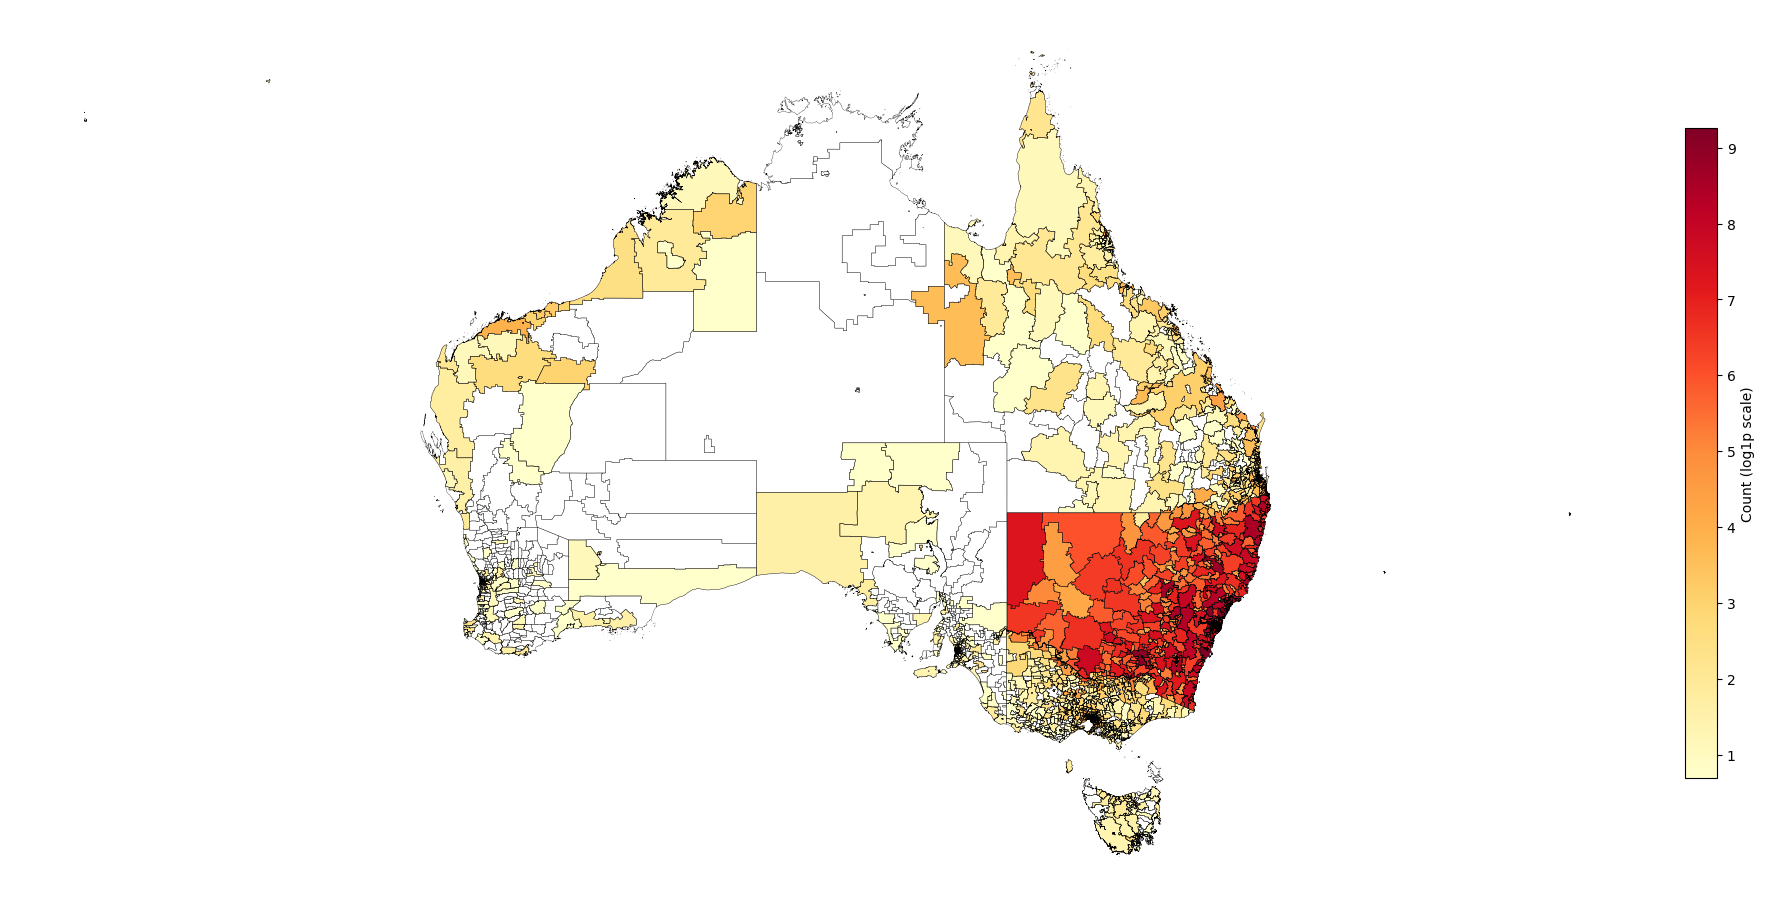

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))

# 1) Borders for zero
gdf_zero.boundary.plot(ax=ax, linewidth=0.2, color="black")

# 2) Choropleth for nonzero using transformed values
gdf_nonzero.plot(
    ax=ax,
    column="count_log",
    cmap="YlOrRd",         # try: "OrRd", "Reds", "viridis"
    legend=True,
    linewidth=0.2,
    legend_kwds={
        "label": "Count (log1p scale)",
        "shrink": 0.33,     # smaller colourbar (0–1)
        "aspect": 20,       # thinner bar (bigger = thinner)
        "pad": 0.02,
    },
)

# 3) Boundaries on top
gdf_nonzero.boundary.plot(ax=ax, linewidth=0.3, color="black")

ax.set_axis_off()
plt.tight_layout()
plt.show()

While this map is great, it is a static figure. Next we’ll build a **Folium version**:  a web map that can be explored easily by people.

The goal is to build a fast-loading interactive choropleth of postcode area polygons coloured by the number of participants (or licences as in our example data). The main practical issues are that the geometries are complex (many vertices), which can make the exported HTML large and slow to render. We also want areas with value = 0 to remain visible as boundaries (to show geographic coverage).


In [19]:
# Start from the merged GeoDataFrame (area polygons + counts attached)
gdf_web = gdfm.copy()
# Keep only the columns we actually need for mapping.
#gdf_web = gdf_web[["postcode", COUNT_COL, "geometry"]].copy()

# Handle skewness of data by transforming values for colouring 
gdf_web["count_log"] = np.log1p(gdf_web[COUNT_COL].astype(float))

# Areas with value = 0: outline-only (transparent fill).
# Folium styles treats NaN differently, so we turn zeros into NaN for the colour field.
# We keep the original total_licences column unchanged for tooltips.
gdf_web.loc[gdf_web[COUNT_COL] <= 0, "count_log"] = np.nan

# Speed-up: simplify geometries before exporting to the browser
# Simplification should be done in a projected CRS (metres). EPSG:3577 is Australian Albers (metre-based).

gdf_simpl = gdf_web.to_crs(epsg=3577).copy()
gdf_simpl["geometry"] = gdf_simpl["geometry"].simplify(
    tolerance=100, # remove vertices while staying within ~100 metres of the original boundary
    preserve_topology=True # helps to avoid self-intersections and broken polygons
)

# Folium/Leaflet expects WGS84 lon/lat coordinates (EPSG:4326), so convert back.
gdf_simpl = gdf_simpl.to_crs(epsg=4326)

# Build a colour scale on the transformed (log) values
# We only scale over non-NaN values (i.e., nonzero licences) so zeros stay transparent.
vals = gdf_simpl["count_log"].dropna().values
vmin, vmax = float(vals.min()), float(vals.max())
cmap = linear.YlOrRd_09.scale(vmin, vmax)
# Caption explains the transform so viewers interpret the map correctly.
cmap.caption = "Counts (log1p scale)"

# Style function: defines how each polygon is drawn
# Leaflet passes each feature's properties; we decide fill colour + opacity + border style.
def style_fn(feat):
    # If lic_log is missing (NaN), this includes zeros (we intentionally set them to NaN above).
    v = feat["properties"].get("count_log", None)

    if v is None:
        # Outline-only: no fill, light boundary so the geographic frame is still visible.
        return {
            "fillOpacity": 0.0,
            "color": "black",
            "weight": 0.3,
            "opacity": 0.15,
        }

    # Nonzero: fill based on the colour map, plus a subtle boundary for readability.
    return {
        "fillColor": cmap(v),
        "fillOpacity": 0.75,
        "color": "black",
        "weight": 0.2,
        "opacity": 0.25,
    }

In the previous cell we prepare everything needed for the interactive choropleth: we create a log-scaled count (`count_log`) to handle skew, set zeros to `NaN` so they plot as outline-only, simplify the POA geometries for faster browser rendering, and define a colour map plus a `style_fn` that controls how each polygon is drawn.

Next we actually build the Folium map: centre it on the POA extent, add the polygons as a single GeoJSON layer with hover tooltips, and optionally save the result as a standalone HTML file.


In [20]:
# Centre map on all areas
centre = gdf_simpl.geometry.union_all().centroid

# prefer_canvas=True can improve rendering performance with many vector features in some browsers.
m = folium.Map(
    location=[centre.y, centre.x],
    zoom_start=4,
    tiles="cartodbpositron",
    prefer_canvas=True,
)

# Add the polygons as a single GeoJSON layer
folium.GeoJson(
    data=gdf_simpl,
    name="POA licences",
    style_function=style_fn,
    smooth_factor=0,
    tooltip=GeoJsonTooltip(
        fields=["postcode", COUNT_COL],
        aliases=["Postcode:", "Count:"],
        localize=True,
    ),
).add_to(m)

m.add_child(cmap)
# Optional: Save as a standalone HTML file (easy to share / open in any browser)
#out_html = "poa_count.html"
#m.save(out_html)
m

NameError: name 'GeoJsonTooltip' is not defined

The next map focuses on Newcastle.

In [ ]:
m = folium.Map(
    location=[-32.9283, 151.7817],  # Newcastle, NSW
    zoom_start=11,
    tiles="cartodbpositron",
    prefer_canvas=True,
)

folium.GeoJson(
    data=gdf_simpl,
    name="POA counts",
    style_function=style_fn,
    smooth_factor=0,
    tooltip=GeoJsonTooltip(
        fields=["postcode", COUNT_COL],
        aliases=["Postcode:", "Count:"],
        localize=True,
    ),
).add_to(m)

m.add_child(cmap)

m

Adding layers lets us separate different kinds of information on the same map and switch them on and off separately as needed. As an example, we add another layer highlighting areas with counts higher than 5k.

In [ ]:
# Optional overlay: highlight only areas with high counts
gdf_hi = gdf_simpl[gdf_simpl[COUNT_COL] > 5000].copy()

folium.GeoJson(
    data=gdf_hi,
    name="POAs > 5000 licences",
    style_function=lambda feat: {
        "fillOpacity": 0.0,     # outline-only highlight (keeps base choropleth visible)
        "color": "cyan",
        "weight": 3,
        "opacity": 0.9,
    },
    tooltip=GeoJsonTooltip(
        fields=["postcode", COUNT_COL],
        aliases=["Postcode:", "Counts:"],
        localize=True,
    ),
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m

Under the colorscale, the layer control is displayed. In this map, we have only one layer (which can be toggled on/off).